# PVC IMPORT PATTERN FORECASTING : weekly forecast - feature forecast



## importing dependencies

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


## Function declaration
Following functions are declared in this section
- function for preprocessing
- function for spliting data into train and testing set
- function for prophet model
- function for XGBoost model 

### Data Preprocessing

In [53]:
def preprocess(dset):

    # selecting only required column
    dset = dset[['ds', 'unitp', 'y']]

    # handling missing values with mean fill method
    dset_mean = dset['unitp'].mean()
    dset['unitp'].fillna(dset_mean, inplace=True)

    dset['cost'] = dset['unitp']*dset['y']

    # formatting date column as per datetime format
    dset['ds'] = pd.to_datetime(dset['ds'], format='mixed')
    dset.sort_values(by='ds', inplace=True)

    # resampling dataset to weekwise frequency
    # resampled_dataset = dset.groupby(pd.Grouper(key='ds', freq='W')).sum().reset_index()
    resampled_dataset = (dset.groupby(pd.Grouper(key='ds', freq='7D', label='left', closed='left')).sum().reset_index())

    # creating lag features
    resampled_dataset['lag_1'] = resampled_dataset['y'].shift(1)
    resampled_dataset.dropna(inplace=True)
    
    return resampled_dataset

### Future Dataset creation: future features are forecasted with prophet

In [54]:
def future_dset(dset):

    # Create a weekly date range from 2024-01-01 to 2024-03-01
    date_range = pd.date_range(start='2025-07-06', end='2025-09-30', freq='7D')

    future_ds = date_range
    future_df = pd.DataFrame(future_ds, columns=['ds'])
    future_df['ds'] = pd.to_datetime(future_df['ds'])
    
    #forecasting future features
    target_list = ['cost', 'lag_1']

    for target in target_list:
        predictor_df = pd.DataFrame()
        predictor_df['ds'] = dset['ds']
        predictor_df['y'] = dset[target]

        model = Prophet(interval_width=0.9)
        model.fit(predictor_df)
        forecast = model.predict(future_df)

        future_df[target] = forecast['yhat']

    future_df.loc[:, 'week'] = future_df['ds'].dt.isocalendar().week
    future_df = future_df[['ds', 'week', 'cost', 'lag_1']]
    
    return future_df

### Training and Testing Data Split
- this function takes the dataset to be predicted
- splits the dataset into training and testing dataset
- split is done in 70:30 ratio
- and returns the training, testing and dataset that can be fitted into the model

In [55]:
def train_test_split(df, size):
    split = int(df['ds'].count()*size)
    
    train = df.iloc[:split+1]
    test = df.iloc[split:]
    
    return train, test

### Prophet: forecasting and plotting
- this function intialises a prophet model
- adds the exogenous variables
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

#### Prophet model hyperparameters tunning


In [56]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('prophet')
logger.setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

prophet_hyperparams_result = pd.DataFrame(columns=['count', 'params', 'mape_upper', 'mape', 'mape_lower'])

def tunner_prophet(dset,list):

    split = int(dset['ds'].count()*0.8)
    train = dset.iloc[:split+1]
    test = dset.iloc[split:]

    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']] 
   
    model = Prophet(interval_width=0.9, changepoint_prior_scale=list[0], seasonality_prior_scale=list[1], seasonality_mode=list[2], changepoint_range=list[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    actual = test['y']
    forecast_total = forecast['yhat']
    forecast_upper = forecast['yhat_upper']
    forecast_lower = forecast['yhat_lower']

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %
    mape_upper = mean_absolute_percentage_error(actual,forecast_upper) * 100 
    mape_lower = mean_absolute_percentage_error(actual,forecast_lower) * 100

    return mape, mape_upper, mape_lower

def tuning_prophet(dset, name):

    dset= dset[['ds', 'cost', 'y']]

    # hyperparameters search space defination
    param1 = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]      # changepoint_prior_scale
    param2 = [0.1, 0.01, 1.0, 5.0, 10.0, 15.0, 20.0, 30.0]       # seasonality_prior_scale
    param3 = ['additive', 'multiplicative']                     # seasonality_mode
    param4 = [0.6, 0.7, 0.8, 0.9, 0.95]                          # changepoint_range

    # calculating total combinations to try
    total_combinations = len(param1) * len(param2) * len(param3) * len(param4)

    # setting best mape as infinity ans best params as none for future update
    best_mape = float('inf')
    best_params = None

    # setting progress bar for total combination 
    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning Prophet", ncols=80) as pbar:
        for mode in param3:
            for cp_range in param4:
                for seas_prior in param2:
                    for cp_prior in param1:
                        params = [cp_prior, seas_prior, mode, cp_range]
                        try:
                            mape, mape_upper, mape_lower = tunner_prophet(dset, params)

                            min_mape = min(mape, mape_upper, mape_lower)
                            if min_mape < best_mape:
                                best_params = params
                                best_mape = min_mape

                            prophet_hyperparams_result.loc[len(prophet_hyperparams_result)] = {'count': count,'name': name, 'params': params,'mape_upper': mape_upper, 'mape': mape, 'mape_lower': mape_lower}

                            count += 1

                        except Exception:
                            pass

                        pbar.update(1)

    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    return best_params, prophet_hyperparams_result


#### Prophet forecast

In [57]:
def prophet_forecast(dset, future, name, params):

    future = future.drop('week', axis=1)

    # train-test forecasting
    model = Prophet(interval_width=0.9, changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], seasonality_mode=params[2], changepoint_range=params[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(dset)
    forecast = fitted_model.predict(future)
    future['predicted_import'] = forecast['yhat']
    future['upper_range'] = forecast['yhat_upper']
    future['lower_range'] = forecast['yhat_lower']

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(dset['ds'], dset['y'], color='orange', label='training data', lw=1)
    plt.plot(future['ds'], forecast['yhat'], color='green', label='test forecast', lw=1)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4, label='confidence interval')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with hyper-tuned Prophet')
    plt.tight_layout()
    plt.show()

    future['product_grade'] = name
    future['model_name'] = 'Prophet'
    
    return future


### XGBoost :forecasting and plotting
- this function intialises a XGBoost model
- process data for model fitting
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

#### XGBoost model hyperparameters tunning

In [58]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
logger = logging.getLogger('xgboost')
logger.setLevel(logging.CRITICAL)

xgb_hyperparams_result = pd.DataFrame(columns=['count', 'name', 'params', 'mape'])

def tunner_xgboost(dset, params):

    split = int(dset['ds'].count()*0.8)
    
    train = dset.iloc[:split+1]
    test = dset.iloc[split:]

    train = train[['ds', 'cost', 'lag_1', 'y']]
    test = test[['ds', 'cost', 'lag_1', 'y']]

    # seggregating features and target for model fitting
    x_train, y_train = train[['ds', 'cost', 'lag_1']], train['y']
    y_test = test[['ds', 'cost', 'lag_1']] 

    # extracting features from datetime columns and droping original datetime column
    x_train.loc[:, 'week'] = x_train['ds'].dt.isocalendar().week
    x_train.drop('ds', axis=1, inplace=True)

    y_test.loc[:, 'week'] = y_test['ds'].dt.isocalendar().week
    y_test.drop('ds', axis=1, inplace=True)

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    
    # forecasting with testing dataset
    forecast = model.predict(y_test)

    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    return mape

def tuning_xgboost(dset, name):

    dset= dset[['ds', 'cost', 'lag_1', 'y']]

    # hyperparameters search space defination
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [100, 200, 300, 500, 700]
    max_depth = [3, 5, 7, 9, 11]
    objective = ['reg:squarederror', 'reg:absoluteerror']
    eval_metric = ['rmse', 'mae']

    # calculating total combinations to try
    total_combinations = len(learning_rate) * len(n_estimators) * len(max_depth) * len(objective) * len(eval_metric) 

    # setting best mape as infinity and best params as none for future update
    best_mape = float('inf')
    best_params = None

    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning XGBoost", ncols=80) as pbar:
        for em in eval_metric:
            for obj in objective:
                for md in max_depth:
                    for ne in n_estimators:
                        for lr in learning_rate:
                            params = [lr, ne, md, obj, em]
                            try:
                                mape = tunner_xgboost(dset, params)

                                if mape < best_mape:
                                    best_params = params
                                    best_mape = mape

                                xgb_hyperparams_result.loc[len(xgb_hyperparams_result)] = {'count': count,'name': name, 'params': params,'mape': mape}
                         
                                count += 1

                            except Exception:
                                pass
                            
                            pbar.update(1)
                        
    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    return best_params, xgb_hyperparams_result


#### XGBoost Forecast

In [59]:
def xgboost_forecast(dset, future, name, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    # seggregating features and target for model fitting
    x_train, y_train = dset[['week', 'cost', 'lag_1']], dset['y']

    # future date forecasting 
    future_model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    future_model.fit(x_train, y_train)
    future_fit = future.drop('ds', axis=1)
    future_forecast = future_model.predict(future_fit)
    future['predicted_import'] = future_forecast

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(dset['ds'], dset['y'], color='orange', label='training data', lw=1)
    plt.plot(future['ds'], future_forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with hyper-tuned XGBoost')
    plt.tight_layout()
    plt.show()

    future['product_grade'] = name
    future['model_name'] = 'XGBoost'

    return future


## Loadind data and preprocessing

In [60]:
df = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/PVC-suspension_lead_time.xlsx')
df = df[['ds', 'k', 'unitp', 'y']]

# converting dates to datetime format & sorting
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df.sort_values(by='ds', inplace=True)

# loading maping dataset
map = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/cat_to_num_mapping.xlsx', engine='openpyxl')

# making dictionary of mapping dataset
k_map =  dict(zip(map['k_level'], map['k_code']))

# mapping grades of df to their code from mapping dataset
df['k_code'] = df['k'].map(k_map)

# dropping previous grade column
df.drop('k', axis=1, inplace=True)

# This will store the final forecast results
prophet_forecast_df = pd.DataFrame(columns=['ds', 'product_grade','cost','lag_1', 'upper_range', 'predicted_import', 'lower_range', 'model_name'])
xgb_forecast_df = pd.DataFrame(columns=['ds', 'product_grade','cost','lag_1', 'upper_range', 'predicted_import', 'lower_range', 'model_name'])
prophet_params_df = pd.DataFrame(columns=['count', 'params', 'mape_upper', 'mape', 'mape_lower'])
xgb_params_df = pd.DataFrame(columns=['count', 'params', 'mape'])

print(df.tail())
print('Total import: ',df['y'].sum())

              ds  unitp        y  k_code
97912 2025-06-04  684.0  280.000     2.0
98220 2025-06-04  676.0   12.398     2.0
98221 2025-06-04  676.0   10.198     2.0
97911 2025-06-04  684.0  280.000     2.0
98199 2025-06-04  676.0  117.404     2.0
Total import:  13013663.026074188


## Forecasting individual K-Level

In [61]:
def k_level_forecast(code, name, p_params, x_params):   

    dset = df[(df['k_code'] == code)]
    
    resampled_dset = preprocess(dset)

    future_df = future_dset(resampled_dset)
    
    if (p_params == None):
        prophet_params, prophet_params_df = tuning_prophet(resampled_dset, name)
    else:
        prophet_params_df = None
        prophet_params = p_params

    ppht_forecast = prophet_forecast(resampled_dset, future_df, name, prophet_params)
    print('Prophet Ouput: ')
    print(ppht_forecast)


    if (x_params == None):
        xgboost_params, xgb_params_df = tuning_xgboost(resampled_dset, name)
    else:
        xgb_params_df = None
        xgboost_params = x_params

    xgb_forecast = xgboost_forecast(resampled_dset, future_df, name, xgboost_params)
    print('XGBoost output: ')
    print(xgb_forecast)

    return ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df

### Very High K

14:07:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


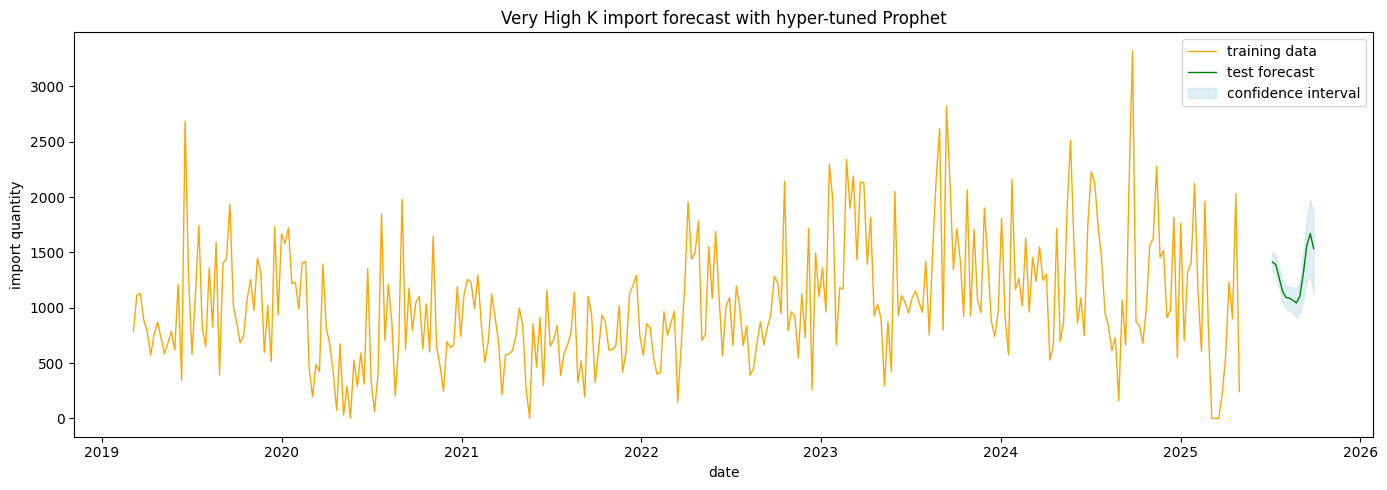

Prophet Ouput: 
           ds          cost        lag_1  predicted_import  upper_range  \
0  2025-07-06  1.107182e+06  1334.338820       1412.175816  1501.607778   
1  2025-07-13  1.087787e+06  1406.335738       1389.361520  1474.856558   
2  2025-07-20  9.916023e+05  1404.211101       1268.263847  1358.476845   
3  2025-07-27  8.940741e+05  1325.908936       1145.105462  1238.574322   
4  2025-08-03  8.513510e+05  1236.332653       1091.891906  1196.065498   
5  2025-08-10  8.456279e+05  1191.770613       1086.046659  1192.975964   
6  2025-08-17  8.294098e+05  1184.784866       1066.683828  1181.587307   
7  2025-08-24  8.097319e+05  1178.011036       1042.808037  1171.148947   
8  2025-08-31  8.571305e+05  1179.551397       1105.365099  1243.753339   
9  2025-09-07  1.013527e+06  1252.123680       1308.847271  1497.773016   
10 2025-09-14  1.206623e+06  1427.579939       1560.340525  1806.148428   
11 2025-09-21  1.289405e+06  1627.450303       1669.669277  1970.425142   
12 2025-0

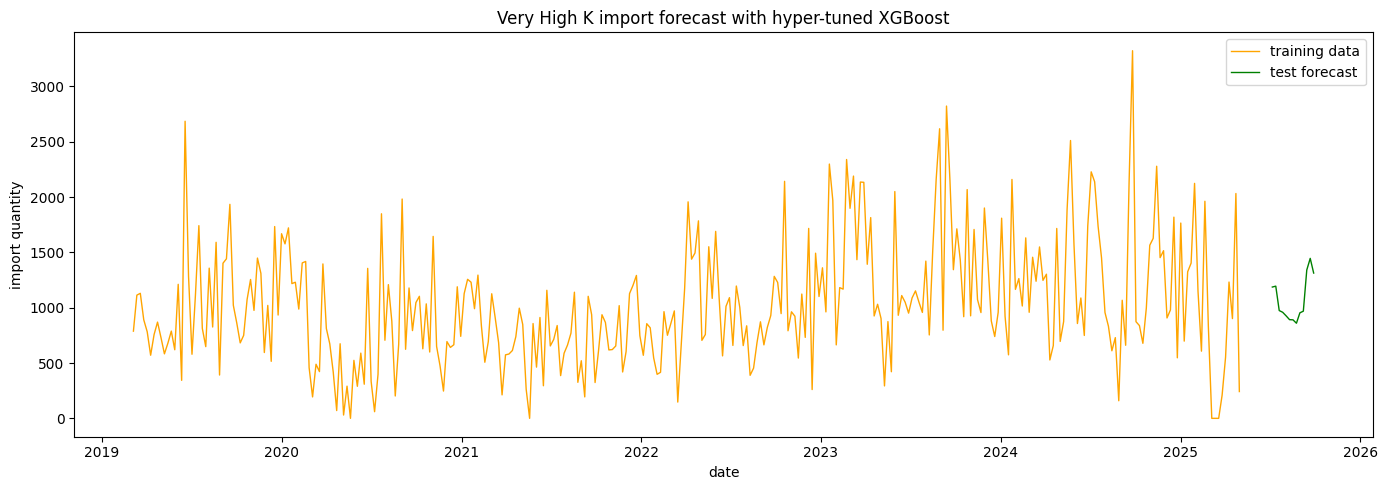

XGBoost output: 
           ds  week          cost        lag_1  predicted_import  \
0  2025-07-06    27  1.107182e+06  1334.338820       1186.662231   
1  2025-07-13    28  1.087787e+06  1406.335738       1194.716797   
2  2025-07-20    29  9.916023e+05  1404.211101        974.169739   
3  2025-07-27    30  8.940741e+05  1325.908936        958.693359   
4  2025-08-03    31  8.513510e+05  1236.332653        926.460388   
5  2025-08-10    32  8.456279e+05  1191.770613        891.886353   
6  2025-08-17    33  8.294098e+05  1184.784866        890.328308   
7  2025-08-24    34  8.097319e+05  1178.011036        859.671814   
8  2025-08-31    35  8.571305e+05  1179.551397        953.655212   
9  2025-09-07    36  1.013527e+06  1252.123680        968.556458   
10 2025-09-14    37  1.206623e+06  1427.579939       1340.768433   
11 2025-09-21    38  1.289405e+06  1627.450303       1445.829102   
12 2025-09-28    39  1.184014e+06  1704.330127       1313.105957   

   product_grade model_name  


In [62]:
prophet_params = [0.001, 0.01, 'multiplicative', 0.8]
xgb_params = [0.1, 200, 11, 'reg:squarederror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params, xgb_params = k_level_forecast(1, 'Very High K', prophet_params, xgb_params) 

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

### High K

14:07:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


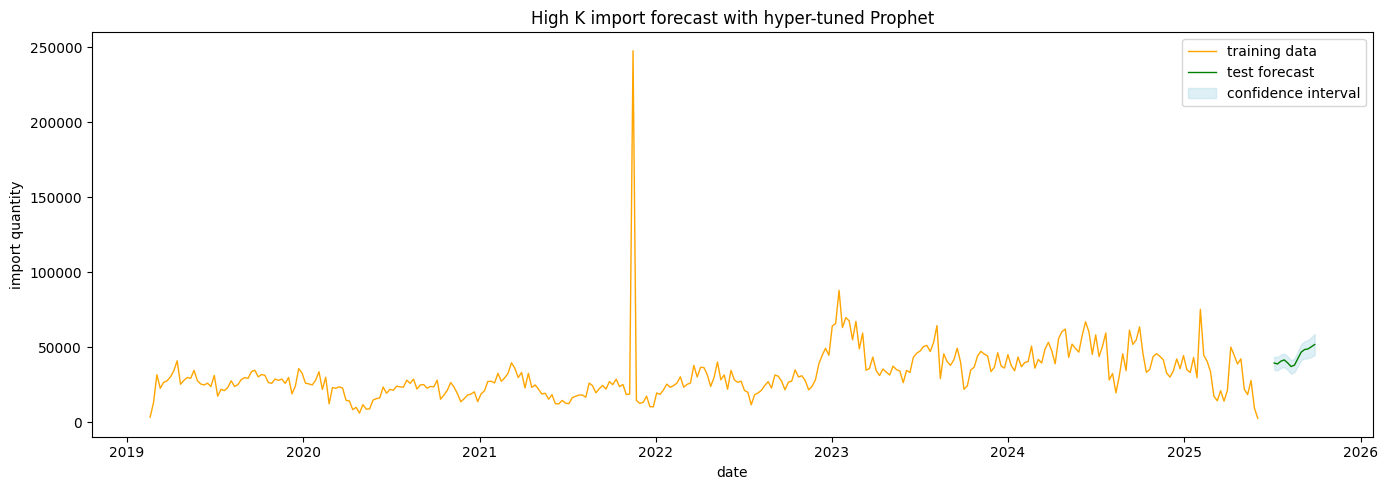

Prophet Ouput: 
           ds          cost         lag_1  predicted_import   upper_range  \
0  2025-07-06  2.399931e+07  39050.208781      39487.874993  43819.611092   
1  2025-07-13  2.347777e+07  37327.524698      38880.754757  43424.613694   
2  2025-07-20  2.427928e+07  37443.031772      40763.256996  45265.501686   
3  2025-07-27  2.451429e+07  38692.856462      41583.195114  45762.562004   
4  2025-08-03  2.326952e+07  38892.740840      39549.278271  43861.366092   
5  2025-08-10  2.186232e+07  37222.739419      37156.761730  41306.123998   
6  2025-08-17  2.215964e+07  35370.275356      38068.187811  42502.791710   
7  2025-08-24  2.419423e+07  35514.497800      42430.949145  47218.839375   
8  2025-08-31  2.618530e+07  37716.820533      46766.373165  52150.147002   
9  2025-09-07  2.685270e+07  40013.388714      48491.432658  54005.281346   
10 2025-09-14  2.685080e+07  40952.602105      48880.685470  54675.925039   
11 2025-09-21  2.736317e+07  41120.830117      50339.449378 

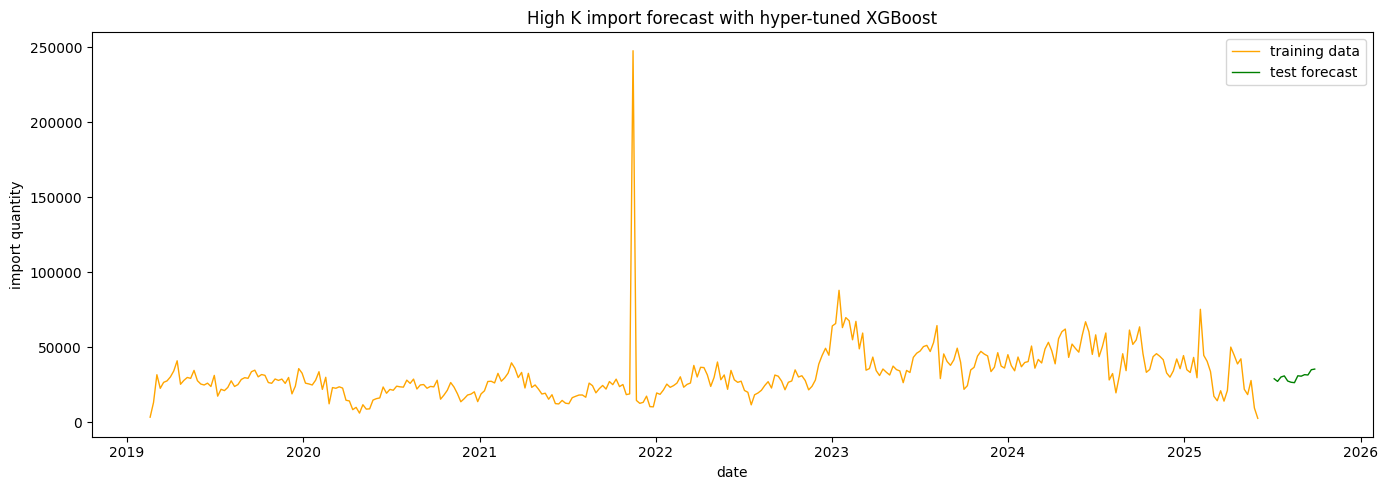

XGBoost output: 
           ds  week          cost         lag_1  predicted_import  \
0  2025-07-06    27  2.399931e+07  39050.208781      28998.625000   
1  2025-07-13    28  2.347777e+07  37327.524698      27251.861328   
2  2025-07-20    29  2.427928e+07  37443.031772      30169.699219   
3  2025-07-27    30  2.451429e+07  38692.856462      30908.761719   
4  2025-08-03    31  2.326952e+07  38892.740840      27507.757812   
5  2025-08-10    32  2.186232e+07  37222.739419      26681.720703   
6  2025-08-17    33  2.215964e+07  35370.275356      26405.162109   
7  2025-08-24    34  2.419423e+07  35514.497800      30986.134766   
8  2025-08-31    35  2.618530e+07  37716.820533      30735.142578   
9  2025-09-07    36  2.685270e+07  40013.388714      31738.957031   
10 2025-09-14    37  2.685080e+07  40952.602105      31523.908203   
11 2025-09-21    38  2.736317e+07  41120.830117      35039.226562   
12 2025-09-28    39  2.787579e+07  41636.353178      35460.410156   

   product_grade

In [63]:
prophet_params = [0.1, 0.01, 'multiplicative', 0.95]
xgb_params = [0.3, 700, 11, 'reg:squarederror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(2, 'High K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

### Medium K

14:07:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


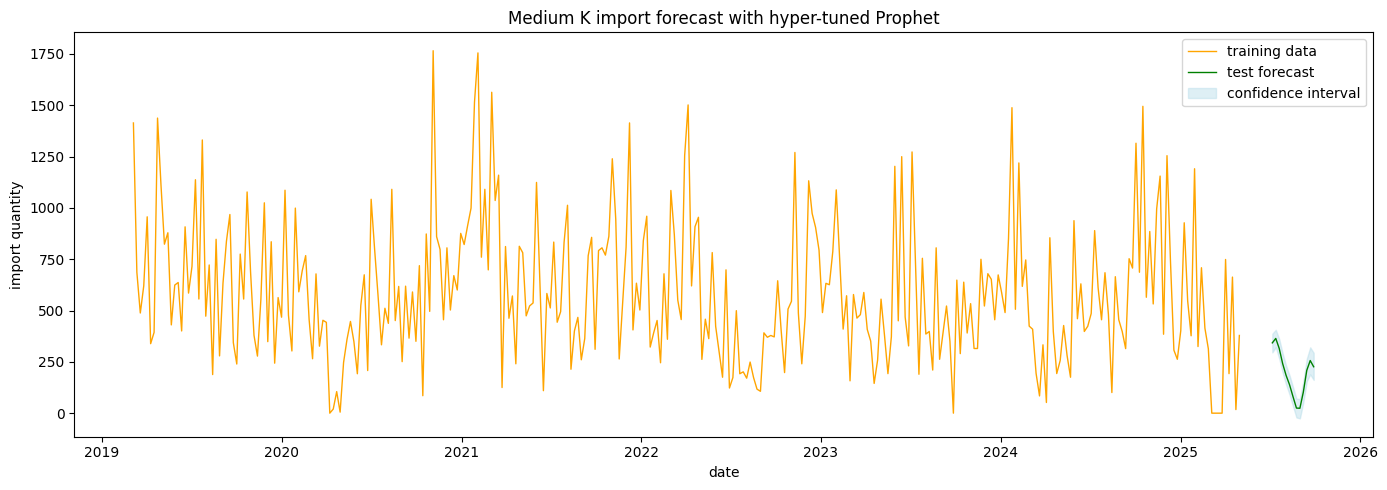

Prophet Ouput: 
           ds           cost       lag_1  predicted_import  upper_range  \
0  2025-07-06  285943.032814  467.067522        342.410489   387.025633   
1  2025-07-13  304132.938711  528.080898        364.093635   406.301743   
2  2025-07-20  263480.266242  540.714375        315.340721   361.210294   
3  2025-07-27  201527.965505  491.196527        241.129221   290.710152   
4  2025-08-03  153722.184689  419.467433        183.879683   231.211615   
5  2025-08-10  115755.370333  370.507795        138.427133   183.580410   
6  2025-08-17   67466.082756  348.417854         80.658472   127.086758   
7  2025-08-24   20755.395888  326.985985         24.807925    70.652225   
8  2025-08-31   19998.542656  297.648040         23.896836    68.633649   
9  2025-09-07   85929.604389  288.710613        102.648333   152.999656   
10 2025-09-14  174647.106186  328.330761        208.569153   264.789838   
11 2025-09-21  214707.832673  399.445732        256.340963   320.673169   
12 2025-0

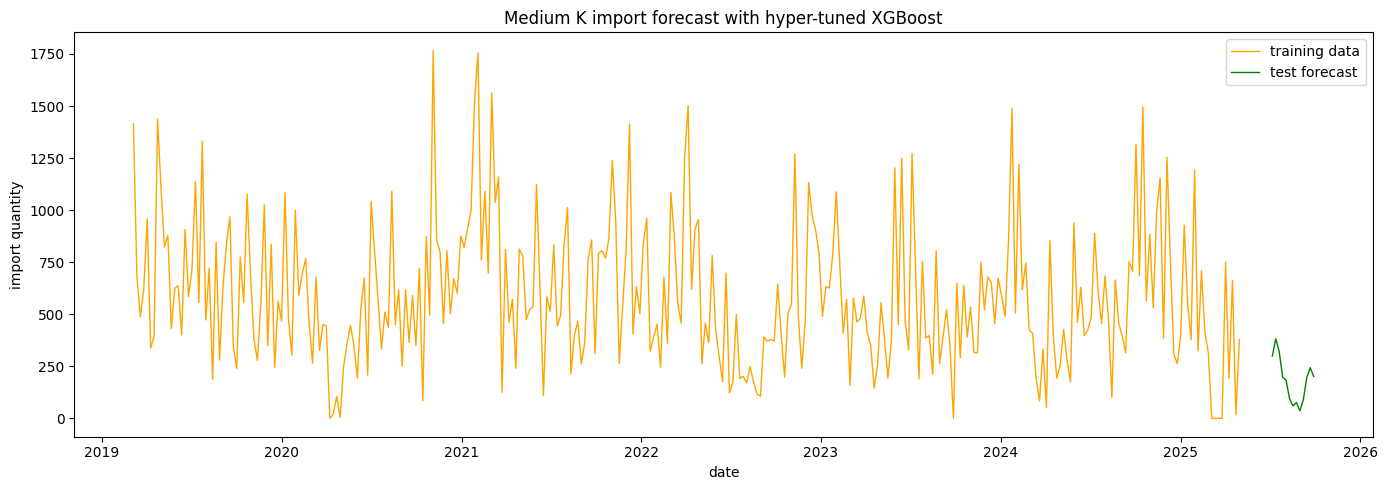

XGBoost output: 
           ds  week           cost       lag_1  predicted_import  \
0  2025-07-06    27  285943.032814  467.067522        299.585327   
1  2025-07-13    28  304132.938711  528.080898        382.140961   
2  2025-07-20    29  263480.266242  540.714375        319.874817   
3  2025-07-27    30  201527.965505  491.196527        198.649307   
4  2025-08-03    31  153722.184689  419.467433        182.708267   
5  2025-08-10    32  115755.370333  370.507795         94.007233   
6  2025-08-17    33   67466.082756  348.417854         59.581715   
7  2025-08-24    34   20755.395888  326.985985         75.737228   
8  2025-08-31    35   19998.542656  297.648040         36.469383   
9  2025-09-07    36   85929.604389  288.710613         89.380333   
10 2025-09-14    37  174647.106186  328.330761        196.621033   
11 2025-09-21    38  214707.832673  399.445732        243.366592   
12 2025-09-28    39  189422.405364  449.914367        200.991959   

   product_grade model_name  


In [64]:
prophet_params = [0.005, 1.0, 'multiplicative', 0.7]
xgb_params = [0.3, 500, 3, 'reg:absoluteerror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(3, 'Medium K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)


### Low K

14:07:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


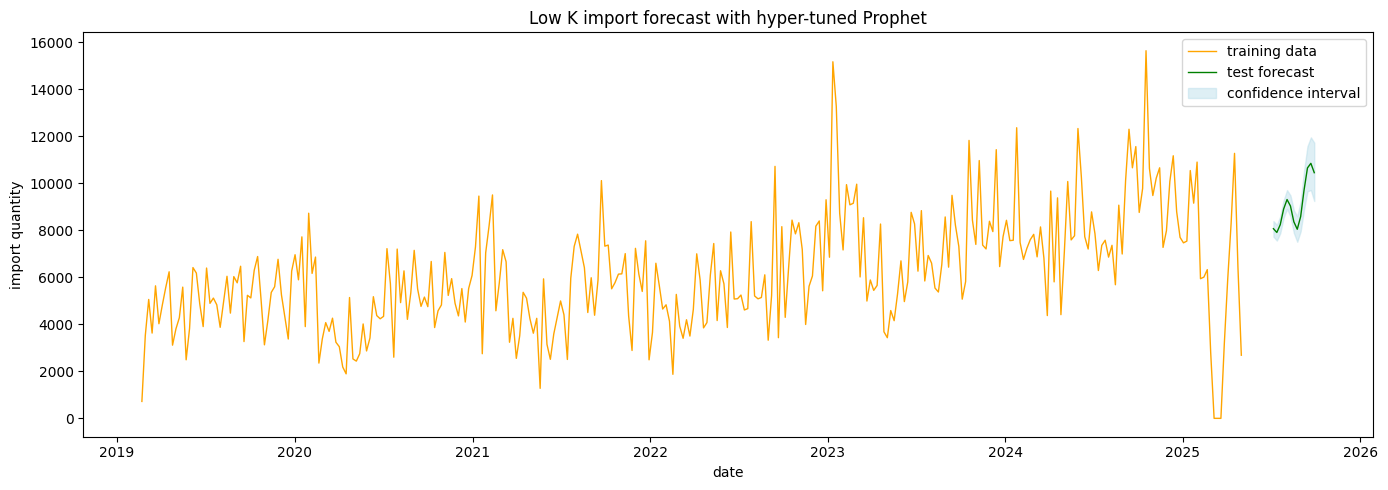

Prophet Ouput: 
           ds          cost        lag_1  predicted_import   upper_range  \
0  2025-07-06  5.522532e+06  8269.949608       8065.965209   8390.558236   
1  2025-07-13  5.379121e+06  8106.729740       7905.032799   8224.682660   
2  2025-07-20  5.569029e+06  7962.415701       8234.357887   8586.878608   
3  2025-07-27  5.983783e+06  8075.433930       8901.595756   9272.986193   
4  2025-08-03  6.217114e+06  8388.138011       9304.789938   9707.027092   
5  2025-08-10  5.997853e+06  8577.697648       9030.744650   9483.207813   
6  2025-08-17  5.517660e+06  8430.789156       8357.514003   8849.131666   
7  2025-08-24  5.277561e+06  8133.773321       8041.450035   8592.303028   
8  2025-08-31  5.597610e+06  8117.436167       8579.610291   9212.927432   
9  2025-09-07  6.296719e+06  8596.158721       9707.957868  10526.894581   
10 2025-09-14  6.866652e+06  9303.064060      10648.598282  11570.970992   
11 2025-09-21  6.952555e+06  9726.811151      10844.536073  11949.760005

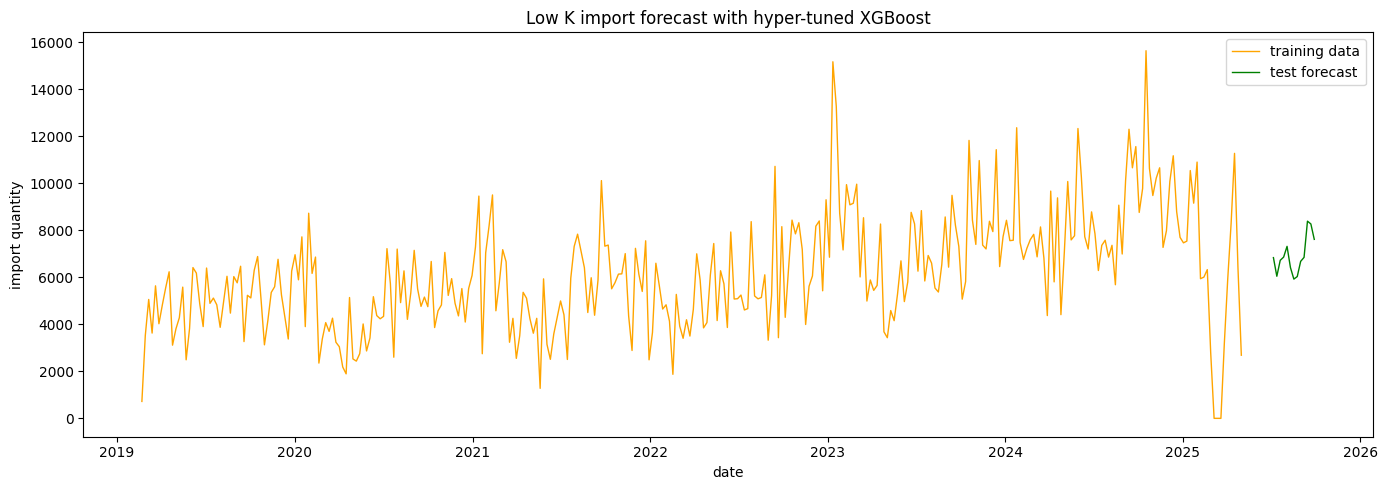

XGBoost output: 
           ds  week          cost        lag_1  predicted_import  \
0  2025-07-06    27  5.522532e+06  8269.949608       6834.769531   
1  2025-07-13    28  5.379121e+06  8106.729740       6042.436523   
2  2025-07-20    29  5.569029e+06  7962.415701       6720.791016   
3  2025-07-27    30  5.983783e+06  8075.433930       6857.710938   
4  2025-08-03    31  6.217114e+06  8388.138011       7314.065918   
5  2025-08-10    32  5.997853e+06  8577.697648       6413.241211   
6  2025-08-17    33  5.517660e+06  8430.789156       5921.346680   
7  2025-08-24    34  5.277561e+06  8133.773321       6029.629883   
8  2025-08-31    35  5.597610e+06  8117.436167       6676.103516   
9  2025-09-07    36  6.296719e+06  8596.158721       6845.865723   
10 2025-09-14    37  6.866652e+06  9303.064060       8385.272461   
11 2025-09-21    38  6.952555e+06  9726.811151       8266.493164   
12 2025-09-28    39  6.659221e+06  9615.528777       7611.300781   

   product_grade model_name  


In [65]:
prophet_params = [0.005, 0.01, 'multiplicative', 0.95]
xgb_params = [0.3, 700, 3, 'reg:absoluteerror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(4, 'Low K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

In [67]:
print(prophet_forecast_df.head())
# print(prophet_params_df.head())

          ds product_grade          cost        lag_1  upper_range  \
0 2025-07-06   Very High K  1.107182e+06  1334.338820  1501.607778   
1 2025-07-13   Very High K  1.087787e+06  1406.335738  1474.856558   
2 2025-07-20   Very High K  9.916023e+05  1404.211101  1358.476845   
3 2025-07-27   Very High K  8.940741e+05  1325.908936  1238.574322   
4 2025-08-03   Very High K  8.513510e+05  1236.332653  1196.065498   

   predicted_import  lower_range model_name  
0       1412.175816  1328.968586    Prophet  
1       1389.361520  1304.421848    Prophet  
2       1268.263847  1183.316132    Prophet  
3       1145.105462  1044.068820    Prophet  
4       1091.891906   987.698021    Prophet  


In [68]:
print(xgb_forecast_df.head())
# print(xgb_params_df.head())

          ds product_grade          cost        lag_1 upper_range  \
0 2025-07-06   Very High K  1.107182e+06  1334.338820         NaN   
1 2025-07-13   Very High K  1.087787e+06  1406.335738         NaN   
2 2025-07-20   Very High K  9.916023e+05  1404.211101         NaN   
3 2025-07-27   Very High K  8.940741e+05  1325.908936         NaN   
4 2025-08-03   Very High K  8.513510e+05  1236.332653         NaN   

   predicted_import lower_range model_name  week  
0       1186.662231         NaN    XGBoost    27  
1       1194.716797         NaN    XGBoost    28  
2        974.169739         NaN    XGBoost    29  
3        958.693359         NaN    XGBoost    30  
4        926.460388         NaN    XGBoost    31  


In [ ]:
# prophet_forecast_df.to_excel('prophet_forecast_output(feature-forecast).xlsx', index=False)
# xgb_forecast_df.to_excel('xgb_forecast_output(feature-forecast).xlsx', index=False)

# prophet_params_df.to_excel('prophet_hyperparams.xlsx', index=False)
# xgb_params_df.to_excel('xgb_hyperparams.xlsx', index=False)